#LS Regressor

In [1]:
%cd /content/drive/My Drive/PMDL/A1/Part2

/content/drive/My Drive/PMDL/A1/Part2


In [2]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip

--2020-10-03 16:07:59--  http://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip.1’

CCPP.zip.1          100%[===================>]   3.50M  5.88MB/s    in 0.6s    

2020-10-03 16:07:59 (5.88 MB/s) - ‘CCPP.zip.1’ saved [3674852/3674852]



In [3]:
!unzip /content/drive/My\ Drive/PMDL/A1/Part2/CCPP.zip

Archive:  /content/drive/My Drive/PMDL/A1/Part2/CCPP.zip
replace CCPP/Folds5x2_pp.ods? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
N
replace CCPP/Folds5x2_pp.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import itertools #easy way to generate combinations from a list of indices
import matplotlib.pyplot as plt


##Load Data

In [5]:
#load first sheet only as we need on version of the dataset
xls = pd.ExcelFile('/content/drive/My Drive/PMDL/A1/Part2/CCPP/Folds5x2_pp.xlsx')
df = pd.read_excel(xls, 'Sheet1')


In [111]:
data=df.values
names=df.columns
X=data[:,:-1]
y=data[:,-1]
#makes sure of the shapes
print(X.shape,y.shape,names)

(9568, 4) (9568,) Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')


In [112]:
#normalize data to be between 0 and 1 (using X=(X-X_min)/ (X_min-X_max))
X=(X-np.min(X,axis=0))/(np.max(X,axis=0)-np.min(X,axis=0))
y=((y-np.min(y))/(np.max(y)-np.min(y))).reshape(-1,1)

In [113]:
X

array([[0.37252125, 0.29181495, 0.77159119, 0.63820375],
       [0.66203966, 0.66903915, 0.6718634 , 0.44932976],
       [0.09348442, 0.24982206, 0.47686216, 0.8924933 ],
       ...,
       [0.83597734, 0.87135231, 0.49566939, 0.1463807 ],
       [0.64220963, 0.78451957, 0.51893096, 0.49369973],
       [0.56062323, 0.66120996, 0.60232616, 0.56715818]])

##LS Regrossor Class

In [9]:
class LS_Regrossor():
  def __init__(self):
    pass

  def poly_features(self,X,m): #generate polynomial features when X has more than 1 feature
    ss=[]
    N=X.shape[0]
    S=list(range(len(X[0,:]))) # get the indicies of the columns
  
    for j in range(2,m+1): #iterate from degree 2 to degree m
      for s in itertools.combinations_with_replacement(S, j): #get all possible subsets of length j 
        ss.append(list(s)) 
    Xn=X.copy()
    for s in ss: #iterate over the generated indices, getting the powers and appending to the X matrix
      V=np.ones((N,1))
     
      for j in s:
       
        V*=X[:,j].reshape(-1,1)
      Xn=np.append(Xn,V,axis=1) # append the colum to X
    return Xn
      
    

  def generate_features(self,X,m=1):
    
    N=X.shape[0]
    d=X.shape[1]
    if d==1:
      Xn=np.c_[ np.ones(N),X ]  # add column of ones
      if m==1:
        return Xn 
      else:
        for i in range(2,m+1):
          Xn=np.append(Xn,X**i,axis=1) #append the powers of the feature to X
        return Xn
    else:
      if m==1:
        return np.c_[ np.ones(N),X ] 
      else:
        Xn=self.poly_features(X,m)
        return np.c_[ np.ones(N),Xn ]  #add columns of ones




  def train(self,X,Y,m=1):
    self.m=m
    Xn=self.generate_features(X,m) #get features at the polynomial degree m
    w=np.dot(np.dot(np.linalg.inv(np.dot(Xn.T,Xn)),Xn.T),Y) #using the normal equation
    self.w=w
    return w
  
  def predict(self,X):
    Xn=self.generate_features(X,self.m)
    y_pred=np.dot(Xn,self.w)
    return y_pred
  
  def compute_loss(self,ypred,ytrue): #return error
    N=ypred.shape[0]
    loss=np.sqrt(np.sum((ypred-ytrue)**2)/N) # E RMS loss
    return loss






##K_fold validation


In [123]:
def K_folds(Xt,yt,n_folds=5,many_ms=False):
  #try diffrent polynomial degree m if many_ms is true
  if many_ms:
    ms=list(range(1,11)) # try ms from 1 to 10
  else:
    ms=[1]
    
  errors_val=[]
  errors_train=[]
 
  groups=np.array(list(range(n_folds)))
  Xs=np.array(np.array_split(Xt,n_folds))
  ys=np.array(np.array_split(yt,n_folds))
  for m in ms: #try all ms ro k-folds
    loss_val=[]
    loss_train=[]
   
    for i in range(n_folds):
      train_groups=groups !=i
      val_groups=groups==i
      Xtr=(np.array(np.concatenate(Xs[train_groups])))
      Xval=(Xs[val_groups])
      Ytr=np.array(np.concatenate(ys[train_groups]))
      Yval=ys[val_groups]

      reg=LS_Regrossor()
      ws=reg.train(Xtr,Ytr,m)
      yp=reg.predict(Xval[0])

      ls=reg.compute_loss(yp,Yval[0])

      loss_val.append(ls)
      ypt=reg.predict(Xtr)
      ls_tr=reg.compute_loss(ypt,Ytr)
      loss_train.append(ls_tr)


    errors_val.append(np.mean(loss_val))
    errors_train.append(np.mean(loss_train))

  return errors_train,errors_val,ms  
        


###Try different m values on Vaccum feature


In [114]:
# feature names: ['AT', 'V', 'AP', 'RH', 'PE'],
Xtrain=X[:,1].reshape(-1,1)
errors_tr_V,errors_val_V,ms=K_folds(Xtrain,y.reshape(-1,1),many_ms=True)

In [115]:
print("min validation loss", np.min(errors_val_V), "it happens at m = ", np.argmin(errors_val_V)+1)

min validation loss 0.10265497950512477 it happens at m =  9


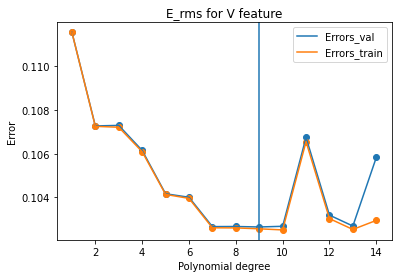

In [116]:

import matplotlib.pyplot as plt
plt.plot(ms,errors_val_V)
plt.plot(ms,errors_tr_V)

plt.scatter(ms,errors_val_V)
plt.scatter(ms,errors_tr_V)
plt.axvline(x=np.argmin(errors_val_V)+1)
plt.legend(("Errors_val","Errors_train"),)
plt.title("E_rms for V feature")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.show() #clearly the best degree polnomial is m= 9 (drew a vetrical line at it)
#note that val and train errors seems to overlap because the difference between them is small

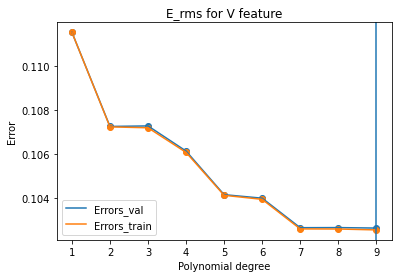

In [117]:
#zoom into the first 8 values of m
plt.plot(ms[:9],errors_val_V[:9])
plt.plot(ms[:9],errors_tr_V[:9])
#plt.plot(ms,errors_sk)
#plt.plot(ms,errors_skt)

plt.scatter(ms[:9],errors_val_V[:9])
plt.scatter(ms[:9],errors_tr_V[:9])
plt.axvline(x=np.argmin(errors_val_V)+1)
plt.legend(("Errors_val","Errors_train"),)
plt.title("E_rms for V feature")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.show()

###Try Linear Reg on feature combinations

In [118]:
def get_subsets(S):
  subsets=[]
  for j in range(1,len(S)+1):
      for ss in itertools.combinations(S, j):
          subsets.append(list(ss))
  return subsets

In [119]:
#get subsets and run K folds on them
subsets=get_subsets([0,1,2,3]) # get combinations of the features (0 being the 1st feature ,etc)
Ers_tr=[]
Ers_val=[]
for s in subsets:
  Xtrain2=X[:,s]
  ert,erv,_=K_folds(Xtrain2,y)
  Ers_tr.append(ert)
  Ers_val.append(erv)



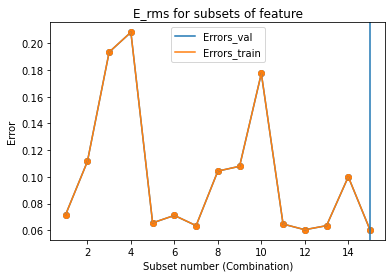

In [120]:
subset_number=list(range(1,16))
plt.plot(subset_number,Ers_tr)
plt.plot(subset_number,Ers_val)
plt.scatter(subset_number,Ers_tr)
plt.scatter(subset_number,Ers_val)
plt.axvline(x=np.argmin(Ers_val)+1) # the vertical line represents the number of the best subset

plt.legend(("Errors_val","Errors_train"),)

plt.title("E_rms for subsets of feature")
plt.xlabel("Subset number (Combination)")
plt.ylabel("Error")

plt.show() #note that val and train errors seems to overlap because the difference between them is small

In [121]:
# print the best combinations of features
feature_names= ['AT', 'V', 'AP', 'RH', 'PE']
min_index=np.argmin(Ers_val)
print("best combination: " ,subsets[min_index])

bst_feat=[]
for s in subsets[min_index]:
  bst_feat.append(feature_names[s])

print("best Combination of Features",bst_feat) # using all features yeild to the best retuls (least error)

best combination:  [0, 1, 2, 3]
best Combination of Features ['AT', 'V', 'AP', 'RH']


###Try all features against the degree of the polynomial

In [124]:
errors_tr,errors_val,ms=K_folds(X,y.reshape(-1,1),many_ms=True)

In [126]:
errors_tr, errors_val


([0.06035412966640894,
  0.05634251861953574,
  0.05493878865493511,
  0.05398756543035268,
  0.05246396999547441,
  0.05151787205522177,
  0.05536890477949141,
  1.2955789174747616,
  55.765018752722995,
  15.463886763615974],
 [0.06038686117126466,
  0.05644754856721992,
  0.055132131041593924,
  0.05447258436930617,
  0.053475957320177715,
  0.053260449015908026,
  0.05922404193510254,
  1.2993695834148344,
  54.225739468909964,
  15.592128265313468])

In [127]:
print("min validation loss", np.min(errors_val), "it happens at m = ", np.argmin(errors_val)+1)

min validation loss 0.053260449015908026 it happens at m =  6


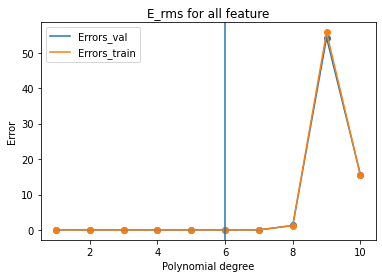

In [128]:
plt.plot(ms,errors_val)
plt.plot(ms,errors_tr)

plt.scatter(ms,errors_val)
plt.scatter(ms,errors_tr)
plt.axvline(x=np.argmin(errors_val)+1)
plt.legend(("Errors_val","Errors_train"),)
plt.title("E_rms for all feature")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.show() #clearly the best degree polnomial is m=2 (drew a vetrical line at it)
#note that val and train errors seems to overlap because the difference between them is small
#the conclusion here is that using all features with low m (m=2) yeilds the lowest error value

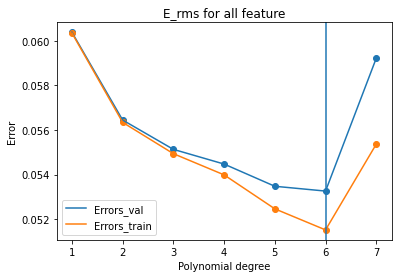

In [131]:
## Zoom into the first 7 m values
plt.plot(ms[:7],errors_val[:7])
plt.plot(ms[:7],errors_tr[:7])

plt.scatter(ms[:7],errors_val[:7])
plt.scatter(ms[:7],errors_tr[:7])
plt.axvline(x=np.argmin(errors_val)+1)
plt.legend(("Errors_val","Errors_train"),)
plt.title("E_rms for all feature")
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.show() #clearly the best degree polnomial is m=6 (drew a vetrical line at it)
#note that val and train errors seems to overlap because the difference between them is small
# the values of the loss are small for small values of m but they explode after about m=8

In [21]:
## Conclusions
# after m=8 , the loss increases significantly especially in part 4, because of the normal equation
# using all featuers yeild the best values for the loss
# using all features with low m (m=6) yeilds the lowest error value (0.008), but after that the error value increases

#####the conclusion here is that using all features with low m (m=2) yeilds the lowest error value

In [22]:
def compute_loss(ypred,ytrue): #return error
    N=ypred.shape[0]
    loss=np.sqrt(np.sum((ypred-ytrue)**2)/N)
    return loss

In [140]:
from sklearn.preprocessing import PolynomialFeatures

In [148]:
pf=PolynomialFeatures(degree=2)
Xn=pf.fit_transform(X)

In [149]:
Xn[0].shape

(15,)

In [64]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression().fit(Xn,y)

In [ ]:
list(itertools.combinations_with_replacement([0,1,2,3],3))

In [68]:
reg=LS_Regrossor()


In [65]:
reg2=LinearRegression()

In [110]:
for m in range(2,10):
  ws=reg.train(X,y,m)
  yp=reg.predict(X)
  pf=PolynomialFeatures(degree=m)
  Xn=pf.fit_transform(X) 
  reg2.fit(X,y)
  yp2=reg2.predict(X)
  print(yp.mean()-yp2.mean()) 



1.659783421814609e-14
6.29958585296464e-12
-8.95349863694328e-10
-6.948932082528891e-09
-5.572315348117973e-06
-0.0002712669272685181
17.057882534138326
2.442711045422784


In [152]:
import itertools
print (list(itertools.combinations_with_replacement([0,1,2,3], 2)))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
